# COMP 579: Assignment 3
March 19th, 2024
Group 86:
- Mathieu Geoffroy 260986559
- Ryan Reszetnik 260948454

## 1. Value-based methods with linear function approximation

### 1.1. Setup Environment

In [1]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import os
import multiprocess

In [2]:
#create a tile encoding of the state space to ma
def create_tiling_for_feature(low, high, num_tiles_per_tiling, num_tilings, x):
    # print(low,high,num_tiles_per_tiling,num_tilings,x)#-1.2 0.6 2 8 [-0.5906537  0.       ]
    num_deltas = (num_tiles_per_tiling - 1) * num_tilings + 1
    tiling = np.linspace(low, high, num_deltas)
    #find the index that x falls into
    idx = np.digitize(x, tiling)
    #idx is 1 indexed
    idx = idx - 1

    representation = np.zeros((num_tilings, num_tiles_per_tiling))
    for i in range(num_tilings):
        one_hot = (idx + num_tilings - i - 1) // num_tiles_per_tiling
        #convert to one hot encoding
        # print(one_hot,num_tilings,i,idx,num_tiles_per_tiling)#4 8 0 2 2
        representation[i][one_hot] = 1
    return representation


def create_tiling(env, num_tiles_per_tiling, num_tilings, state):
    low = env.observation_space.low
    high = env.observation_space.high
    num_features = len(low)
    tiling = np.zeros((num_features, num_tilings, num_tiles_per_tiling))
    for i in range(num_features):
        tiling[i] = create_tiling_for_feature(low[i], high[i], num_tiles_per_tiling, num_tilings, state[i])
    return tiling


def create_flat_tiling(env, num_tiles_per_tiling, num_tilings, state):
    tiling = create_tiling(env, num_tiles_per_tiling, num_tilings, state)
    flat_tiling = tiling.flatten()
    return flat_tiling


#test the tiling
mtn_car = gym.make('MountainCar-v0')
state = mtn_car.reset()
print(state)
print(create_tiling(mtn_car, 8, 2, state[0]))
tiling = create_flat_tiling(mtn_car, 8, 2, state[0])
print(tiling)

(array([-0.52914524,  0.        ], dtype=float32), {})
[[[1. 0. 0. 0. 0. 0. 0. 0.]
  [1. 0. 0. 0. 0. 0. 0. 0.]]

 [[0. 1. 0. 0. 0. 0. 0. 0.]
  [1. 0. 0. 0. 0. 0. 0. 0.]]]
[1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.
 1. 0. 0. 0. 0. 0. 0. 0.]


In [3]:
class Q_Network():
    def __init__(self, input_dim, output_dim):
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.weights = np.random.uniform(-0.001, 0.001, (input_dim, output_dim))

    def forward(self, x):
        return x @ self.weights

    def backward(self, x, y_hat, lr):
        self.weights = self.weights + lr * x.T @ (y_hat - x @ self.weights)


#test the Q network to make sure it trains
q_network = Q_Network(16, 3)
eg_input = np.random.uniform(-1, 1, (1, 16))
eg_output = np.random.uniform(-1, 1, (1, 3))

for i in range(1000):
    y_hat = q_network.forward(eg_input)
    q_network.backward(eg_input, eg_output, 0.01)
    if i % 100 == 0:
        print(np.mean(np.square(y_hat - eg_output)))



0.17816243768730997
3.249264665509754e-08
5.925896055061867e-15
1.080741114779431e-21
1.9729335486333025e-28
7.498287250147638e-32
7.498287250147638e-32
7.498287250147638e-32
7.498287250147638e-32
7.498287250147638e-32


### 1.2 Q-learning with linear function approximation

In [4]:
def epsilon_greedy(q_values, epsilon):
    if np.random.rand() < epsilon:
        return np.random.randint(len(q_values))
    else:
        return np.argmax(q_values)


class QLearning:
    def __init__(self, env, alpha, gamma, epsilon, num_tilings, num_tiles_per_tiling):
        # write your solution here
        self.env = env
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.num_tilings = num_tilings
        self.num_tiles_per_tiling = num_tiles_per_tiling
        self.Q = Q_Network(num_tilings * num_tiles_per_tiling * len(env.observation_space.low), env.action_space.n)

    def reset(self):
        self.Q = Q_Network(self.num_tilings * self.num_tiles_per_tiling * len(self.env.observation_space.low),
                           self.env.action_space.n)

    def select_action(self, s):
        tile_coding_state = create_flat_tiling(self.env, self.num_tiles_per_tiling, self.num_tilings, s)
        q_values = self.Q.forward(tile_coding_state)
        action = epsilon_greedy(q_values, self.epsilon)
        return action

    def update(self, s, a, r, s_prime):
        tile_coding_state = create_flat_tiling(self.env, self.num_tiles_per_tiling, self.num_tilings, s)
        q_values = self.Q.forward(tile_coding_state)
        next_tile_coding_state = create_flat_tiling(self.env, self.num_tiles_per_tiling, self.num_tilings, s_prime)
        next_q_values = self.Q.forward(next_tile_coding_state)
        next_action = np.argmax(next_q_values)
        target = r + self.gamma * next_q_values[next_action]
        q_values[a] = q_values[a] + self.alpha * (target - q_values[a])
        self.Q.backward(tile_coding_state.reshape(1, -1), q_values.reshape(1, -1), self.alpha)
        return


class ExpectedSarsa:
    def __init__(self, env, alpha, gamma, epsilon, num_tilings, num_tiles_per_tiling):
        # write your solution here
        self.env = env
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.num_tilings = num_tilings
        self.num_tiles_per_tiling = num_tiles_per_tiling
        self.Q = Q_Network(num_tilings * num_tiles_per_tiling * len(env.observation_space.low), env.action_space.n)

    def reset(self):
        self.Q = Q_Network(self.num_tilings * self.num_tiles_per_tiling * len(self.env.observation_space.low),
                           self.env.action_space.n)

    def select_action(self, s):
        tile_coding_state = create_flat_tiling(self.env, self.num_tiles_per_tiling, self.num_tilings, s)
        q_values = self.Q.forward(tile_coding_state)
        action = epsilon_greedy(q_values, self.epsilon)
        return action

    def update(self, s, a, r, s_prime):
        tile_coding_state = create_flat_tiling(self.env, self.num_tiles_per_tiling, self.num_tilings, s)
        q_values = self.Q.forward(tile_coding_state)
        next_tile_coding_state = create_flat_tiling(self.env, self.num_tiles_per_tiling, self.num_tilings, s_prime)
        next_q_values = self.Q.forward(next_tile_coding_state)
        expected_value = np.sum(next_q_values * (1 - self.epsilon) + self.epsilon / self.env.action_space.n)
        target = r + self.gamma * expected_value
        q_values[a] = q_values[a] + self.alpha * (target - q_values[a])
        self.Q.backward(tile_coding_state.reshape(1, -1), q_values.reshape(1, -1), self.alpha)
        return

In [5]:
def run_episoid(agent, env):
    state = env.reset()[0]
    cum_reward = 0
    while True:
        action = agent.select_action(state)
        next_state, reward, terminated, truncated, _ = env.step(action)
        agent.update(state, action, reward, next_state)
        cum_reward += reward
        state = next_state
        if terminated or truncated:
            break
    return cum_reward


def run_experiments(agent, env, num_episodes, num_experiments, experiment_id):
    rewards = []
    for k in range(num_experiments):
        agent.reset()
        episoid_rewards = []
        for i in range(num_episodes):
            reward = run_episoid(agent, env)
            episoid_rewards.append(reward)
        rewards.append(episoid_rewards)
        print("Finished experiment", k, "on experiment", experiment_id)
    return np.array(rewards)

In [6]:
alphas = [1 / 4, 1 / 8, 1 / 16]
epsilons = [1 / 4, 1 / 8, 1 / 16]
GAMMA = 0.99
NUM_TILINGS = 4
NUM_TILES_PER_TILING = 7
NUM_EPISOIDS = 1000
NUM_EXPERIMENTS = 50

NUM_PROCESSES = 8
SAVE_FOLDER = "results"


def get_experiment_id(alpha, epsilon, isMountainCar, algorithm, temp=0, isDecreaseTemp=False):
    experiment_name = "mountain_car" if isMountainCar else "cart_pole"

    return "{}-{}-{}-{}-{}-{}-{}-{}-{}-{}-{}".format(alpha, epsilon, GAMMA, NUM_TILINGS, NUM_TILES_PER_TILING,
                                                     NUM_EPISOIDS, NUM_EXPERIMENTS, experiment_name, algorithm, temp,
                                                     isDecreaseTemp)


In [7]:
def run_experiment(alpha, epsilon, isMountainCar, algorithm):
    experiment_id = get_experiment_id(alpha, epsilon, isMountainCar, algorithm)
    SAVE_PATH = SAVE_FOLDER + "/" + algorithm
    try:
        os.mkdir(SAVE_PATH)
    except:
        pass
    try:
        rewards = np.load("{}/{}.npy".format(SAVE_PATH, experiment_id))
        print("Loaded experiment", get_experiment_id(alpha, epsilon, isMountainCar, algorithm))
        return rewards
    except:
        pass

    env = gym.make('MountainCar-v0') if isMountainCar else gym.make('CartPole-v1')

    if algorithm == 'q_learning':
        agent = QLearning(env, alpha, GAMMA, epsilon, NUM_TILINGS, NUM_TILES_PER_TILING)
    else:
        agent = ExpectedSarsa(env, alpha, GAMMA, epsilon, NUM_TILINGS, NUM_TILES_PER_TILING)
    rewards = run_experiments(agent, env, NUM_EPISOIDS, NUM_EXPERIMENTS, experiment_id)

    print("Finished experiment", experiment_id)
    np.save("{}/{}.npy".format(SAVE_PATH, experiment_id), rewards)
    return rewards

Loaded experimentLoaded experimentLoaded experimentLoaded experimentLoaded experimentLoaded experimentLoaded experiment       0.25-0.125-0.99-4-7-1000-50-mountain_car-q_learning-0-False0.25-0.25-0.99-4-7-1000-50-mountain_car-q_learning-0-False0.25-0.0625-0.99-4-7-1000-50-mountain_car-q_learning-0-FalseLoaded experiment0.125-0.25-0.99-4-7-1000-50-mountain_car-q_learning-0-False0.125-0.125-0.99-4-7-1000-50-mountain_car-q_learning-0-False0.125-0.0625-0.99-4-7-1000-50-mountain_car-q_learning-0-False0.0625-0.25-0.99-4-7-1000-50-mountain_car-q_learning-0-False



 


0.0625-0.125-0.99-4-7-1000-50-mountain_car-q_learning-0-False
Loaded experiment 0.0625-0.0625-0.99-4-7-1000-50-mountain_car-q_learning-0-False


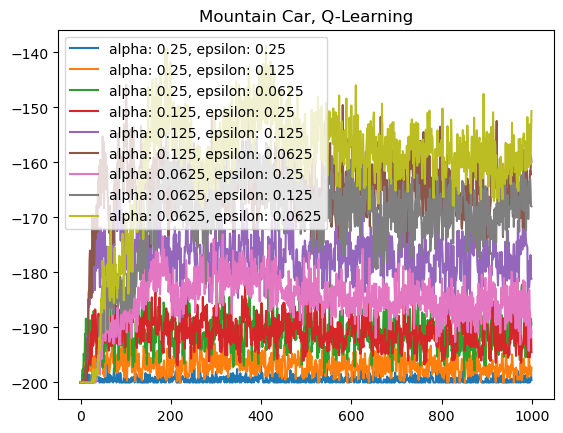

In [20]:
#mountain car, q learning
results = []
labels = []
experiments = []
for alpha in alphas:
    for epsilon in epsilons:
        params = {
            'alpha': alpha,
            'epsilon': epsilon,
            'isMountainCar': True,
            'algorithm': 'q_learning'
        }
        experiments.append(params)
        labels.append("alpha: {}, epsilon: {}".format(alpha, epsilon))

with multiprocess.Pool(processes=NUM_PROCESSES) as pool:
    results = pool.starmap(run_experiment, [
        (experiment['alpha'], experiment['epsilon'], experiment['isMountainCar'], experiment['algorithm']) for
        experiment in experiments])

for result, label in zip(results, labels):
    plt.plot(np.mean(result, axis=0), label=label)

plt.title("Mountain Car, Q-Learning")
plt.legend()
plt.show()

Loaded experimentLoaded experimentLoaded experimentLoaded experimentLoaded experimentLoaded experimentLoaded experiment   Loaded experiment    0.25-0.125-0.99-4-7-1000-50-mountain_car-expected_sarsa-0-False0.125-0.125-0.99-4-7-1000-50-mountain_car-expected_sarsa-0-False0.25-0.0625-0.99-4-7-1000-50-mountain_car-expected_sarsa-0-False0.125-0.25-0.99-4-7-1000-50-mountain_car-expected_sarsa-0-False0.125-0.0625-0.99-4-7-1000-50-mountain_car-expected_sarsa-0-False 0.25-0.25-0.99-4-7-1000-50-mountain_car-expected_sarsa-0-False0.0625-0.125-0.99-4-7-1000-50-mountain_car-expected_sarsa-0-False



0.0625-0.25-0.99-4-7-1000-50-mountain_car-expected_sarsa-0-False



Loaded experiment 0.0625-0.0625-0.99-4-7-1000-50-mountain_car-expected_sarsa-0-False


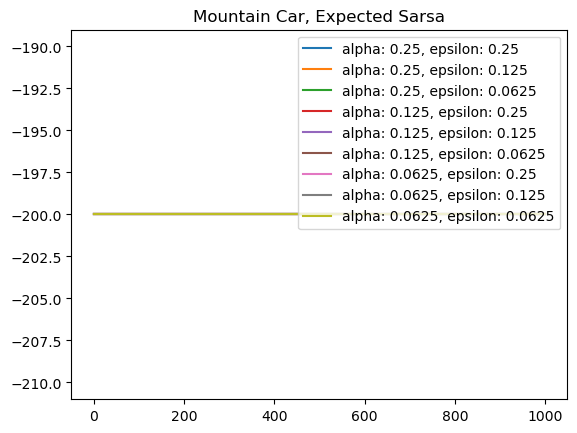

In [21]:
#mountain car, expected sarsa
results = []
labels = []
experiments = []
for alpha in alphas:
    for epsilon in epsilons:
        params = {
            'alpha': alpha,
            'epsilon': epsilon,
            'isMountainCar': True,
            'algorithm': 'expected_sarsa'
        }
        experiments.append(params)
        labels.append("alpha: {}, epsilon: {}".format(alpha, epsilon))

with multiprocess.Pool(processes=NUM_PROCESSES) as pool:
    results = pool.starmap(run_experiment, [
        (experiment['alpha'], experiment['epsilon'], experiment['isMountainCar'], experiment['algorithm']) for
        experiment in experiments])

for result, label in zip(results, labels):
    plt.plot(np.mean(result, axis=0), label=label)

plt.title("Mountain Car, Expected Sarsa")
plt.legend()
plt.show()

Loaded experimentLoaded experimentLoaded experimentLoaded experimentLoaded experimentLoaded experimentLoaded experimentLoaded experiment        0.25-0.25-0.99-4-7-1000-50-cart_pole-q_learning-0-False0.25-0.0625-0.99-4-7-1000-50-cart_pole-q_learning-0-False0.25-0.125-0.99-4-7-1000-50-cart_pole-q_learning-0-False0.125-0.0625-0.99-4-7-1000-50-cart_pole-q_learning-0-False0.125-0.25-0.99-4-7-1000-50-cart_pole-q_learning-0-False0.125-0.125-0.99-4-7-1000-50-cart_pole-q_learning-0-False0.0625-0.25-0.99-4-7-1000-50-cart_pole-q_learning-0-False0.0625-0.125-0.99-4-7-1000-50-cart_pole-q_learning-0-False







Loaded experiment 0.0625-0.0625-0.99-4-7-1000-50-cart_pole-q_learning-0-False


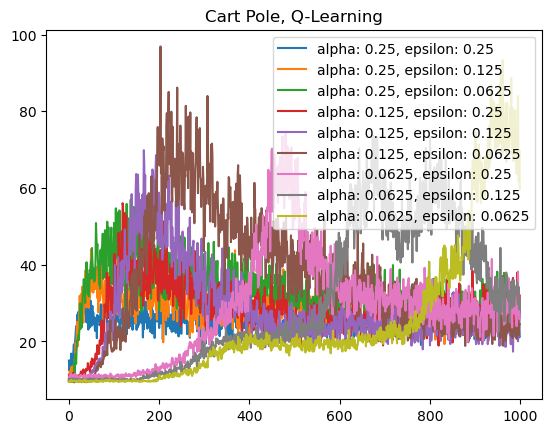

In [22]:
#cart pole, q learning
results = []
labels = []
experiments = []
for alpha in alphas:
    for epsilon in epsilons:
        params = {
            'alpha': alpha,
            'epsilon': epsilon,
            'isMountainCar': False,
            'algorithm': 'q_learning'
        }
        experiments.append(params)
        labels.append("alpha: {}, epsilon: {}".format(alpha, epsilon))

with multiprocess.Pool(processes=NUM_PROCESSES) as pool:
    results = pool.starmap(run_experiment, [
        (experiment['alpha'], experiment['epsilon'], experiment['isMountainCar'], experiment['algorithm']) for
        experiment in experiments])

for result, label in zip(results, labels):
    plt.plot(np.mean(result, axis=0), label=label)
plt.title("Cart Pole, Q-Learning")
plt.legend()
plt.show()

Loaded experimentLoaded experimentLoaded experimentLoaded experimentLoaded experimentLoaded experiment    Loaded experimentLoaded experiment  0.25-0.0625-0.99-4-7-1000-50-cart_pole-expected_sarsa-0-False0.25-0.25-0.99-4-7-1000-50-cart_pole-expected_sarsa-0-False0.125-0.125-0.99-4-7-1000-50-cart_pole-expected_sarsa-0-False0.125-0.25-0.99-4-7-1000-50-cart_pole-expected_sarsa-0-False  0.25-0.125-0.99-4-7-1000-50-cart_pole-expected_sarsa-0-False0.125-0.0625-0.99-4-7-1000-50-cart_pole-expected_sarsa-0-False



0.0625-0.125-0.99-4-7-1000-50-cart_pole-expected_sarsa-0-False0.0625-0.25-0.99-4-7-1000-50-cart_pole-expected_sarsa-0-False



Loaded experiment 0.0625-0.0625-0.99-4-7-1000-50-cart_pole-expected_sarsa-0-False


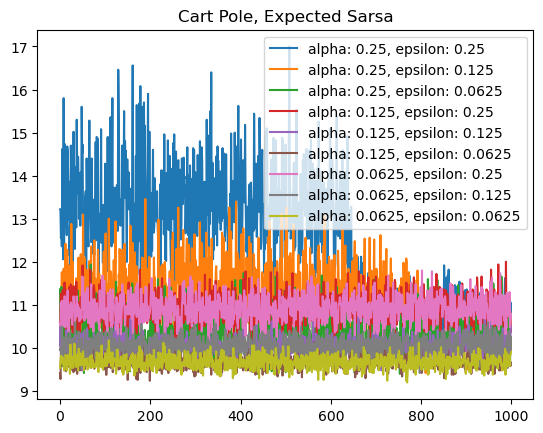

In [23]:
#cart pole, expected sarsa
results = []
labels = []
experiments = []
for alpha in alphas:
    for epsilon in epsilons:
        params = {
            'alpha': alpha,
            'epsilon': epsilon,
            'isMountainCar': False,
            'algorithm': 'expected_sarsa'
        }
        experiments.append(params)
        labels.append("alpha: {}, epsilon: {}".format(alpha, epsilon))

with multiprocess.Pool(processes=NUM_PROCESSES) as pool:
    results = pool.starmap(run_experiment, [
        (experiment['alpha'], experiment['epsilon'], experiment['isMountainCar'], experiment['algorithm']) for
        experiment in experiments])

for result, label in zip(results, labels):
    plt.plot(np.mean(result, axis=0), label=label)

plt.title("Cart Pole, Expected Sarsa")
plt.legend()
plt.show()

## 2. Policy Gradient Theorem

## 3. Policy-based methods with linear function approximation

### 3.1 Approximators

In [24]:
class BoltzmannPolicyApproximator:
    def __init__(self, input_dim, output_dim, temp):
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.weights = np.random.uniform(-0.001, 0.001, (input_dim, output_dim))
        self.temp = temp

    def forward(self, x):
        # overflow safe boltzmann
        z = x @ self.weights
        z -= np.max(z)
        return np.exp(z / self.temp) / np.sum(np.exp(z / self.temp))

    def reinforce_backward(self, x, a, G, alpha, gamma, time_step):
        probs = self.forward(x)
        for i in range(self.output_dim):
            if i == a:
                self.weights[:, i] += alpha * (gamma ** time_step) * G * x * (1 - probs[i])
            else:
                self.weights[:, i] -= alpha * (gamma ** time_step) * G * x * probs[i]

    def actor_critic_backward(self, x, a, I, delta, alpha):
        probs = self.forward(x)
        for i in range(self.output_dim):
            if i == a:
                self.weights[:, i] += alpha * I * delta * x * (1 - probs[i])
            else:
                self.weights[:, i] -= alpha * I * delta * x * probs[i]


class QNetworkApproximator:
    def __init__(self, input_dim, output_dim):
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.weights = np.random.uniform(-0.001, 0.001, (input_dim, output_dim))

    def forward(self, x):
        return x @ self.weights

    def backward(self, x, a, alpha, delta):
        self.weights[:, a] += alpha * delta * x


### 3.2 REINFORCE with linear function approximation

In [31]:
class Reinforce:
    def __init__(self, env, alpha, gamma, num_tilings, num_tiles_per_tiling, temp=0.1):
        self.env = env
        self.alpha = alpha
        self.gamma = gamma
        self.num_tilings = num_tilings
        self.num_tiles_per_tiling = num_tiles_per_tiling
        self.policy = BoltzmannPolicyApproximator(num_tilings * num_tiles_per_tiling * len(env.observation_space.low),
                                                  env.action_space.n, temp)

    def select_action(self, s):
        tile_coding_state = create_flat_tiling(self.env, self.num_tiles_per_tiling, self.num_tilings, s)
        probs = self.policy.forward(tile_coding_state)
        action = np.random.choice(self.env.action_space.n, p=probs)
        return action

    def update_policy(self, states, actions, rewards):
        for t in range(len(states)):
            G = np.sum([self.gamma ** i * rewards[t + i] for i in range(len(states) - t)])
            tile_coding_state = create_flat_tiling(self.env, self.num_tiles_per_tiling, self.num_tilings, states[t])
            self.policy.reinforce_backward(tile_coding_state, actions[t], G, self.alpha, self.gamma, t)

    def decrease_temp(self):
        self.policy.temp *= 0.999

    def generate_episode(self):
        states = []
        actions = []
        rewards = []
        state = self.env.reset()[0]
        count = 0
        while True:
            action = self.select_action(state)
            next_state, reward, terminated, truncated, _ = self.env.step(action)
            states.append(state)
            actions.append(action)
            rewards.append(reward)
            state = next_state
            if terminated or count > 10000:
                break
            count += 1
        return states, actions, rewards

    def train(self, num_episodes, decrease_temp=False):
        cum_reward = []
        for i in range(num_episodes):
            states, actions, rewards = self.generate_episode()
            self.update_policy(states, actions, rewards)
            if decrease_temp:
                self.decrease_temp()
            cum_reward.append(np.sum(rewards))
        return cum_reward

### 3.3 Actor-Critic with linear function approximation

In [32]:
class Actor_Critic:
    def __init__(self, env, alpha_policy, alpha_value, gamma, num_tilings, num_tiles_per_tiling, temp=0.1):
        self.env = env
        self.alpha_policy = alpha_policy
        self.alpha_value = alpha_value
        self.gamma = gamma
        self.num_tilings = num_tilings
        self.num_tiles_per_tiling = num_tiles_per_tiling
        self.policy = BoltzmannPolicyApproximator(num_tilings * num_tiles_per_tiling * len(env.observation_space.low),
                                                  env.action_space.n, temp)
        self.value = QNetworkApproximator(num_tilings * num_tiles_per_tiling * len(env.observation_space.low),
                                          env.action_space.n)

    def select_action(self, s):
        tile_coding_state = create_flat_tiling(self.env, self.num_tiles_per_tiling, self.num_tilings, s)
        probs = self.policy.forward(tile_coding_state)
        action = np.random.choice(self.env.action_space.n, p=probs)
        return action

    def decrease_temp(self):
        self.policy.temp *= 0.999

    def calculate_delta(self, s, a, r, s_prime):
        tile_coding_state = create_flat_tiling(self.env, self.num_tiles_per_tiling, self.num_tilings, s)
        q_values = self.value.forward(tile_coding_state)
        next_tile_coding_state = create_flat_tiling(self.env, self.num_tiles_per_tiling, self.num_tilings, s_prime)
        next_q_values = self.value.forward(next_tile_coding_state)
        next_action = self.select_action(s_prime)
        delta = r + self.gamma * next_q_values[next_action] - q_values[a]
        return delta

    def update_policy(self, s, a, I, delta):
        tile_coding_state = create_flat_tiling(self.env, self.num_tiles_per_tiling, self.num_tilings, s)
        self.policy.actor_critic_backward(tile_coding_state, a, I, delta, self.alpha_policy)

    def update_value(self, s, a, delta):
        tile_coding_state = create_flat_tiling(self.env, self.num_tiles_per_tiling, self.num_tilings, s)
        self.value.backward(tile_coding_state, a, self.alpha_value, delta)

    def train(self, num_episodes, decrease_temp=False):
        cum_reward = []
        for i in range(num_episodes):
            states = []
            actions = []
            rewards = []
            log_probs = []
            state = self.env.reset()[0]
            I = 1
            while True:
                action = self.select_action(state)
                next_state, reward, terminated, truncated, _ = self.env.step(action)
                delta = self.calculate_delta(state, action, reward, next_state)
                self.update_policy(state, action, I, delta)
                self.update_value(state, action, delta)
                states.append(state)
                actions.append(action)
                rewards.append(reward)
                if terminated or truncated:
                    break
                state = next_state
                I *= self.gamma

            if decrease_temp:
                self.decrease_temp()

            cum_reward.append(np.sum(rewards))
        return cum_reward

### 3.4 Experiment Helper Functions

In [38]:
def run_experiment_q3(algorithm, alpha, gamma, num_tilings, num_tiles_per_tiling, temp, num_episodes, num_trials,
                      isMountainCar,
                      decrease_temp=False):
    experiement_id = get_experiment_id(alpha, temp, isMountainCar, algorithm, temp, decrease_temp)
    SAVE_PATH = SAVE_FOLDER + "/" + algorithm
    try:
        os.mkdir(SAVE_PATH)
    except:
        pass
    try:
        rewards = np.load("{}/{}.npy".format(SAVE_PATH, experiement_id))
        print("Loaded experiment", experiement_id)
        return rewards
    except:
        pass

    rewards = run_experiments_q3(algorithm, alpha, gamma, num_tilings, num_tiles_per_tiling, temp, num_episodes,
                                 num_trials, isMountainCar,
                                 decrease_temp)

    print("Finished experiment", experiement_id)

    np.save("{}/{}.npy".format(SAVE_PATH, experiement_id), rewards)

    return rewards

In [39]:
def run_experiments_q3(algorithm, alpha, gamma, num_tilings, num_tiles_per_tiling, temp, num_episodes, num_trials,
                       isMountainCar,
                       decrease_temp=False):
    rewards = []
    for i in range(num_trials):
        env = gym.make('MountainCar-v0') if isMountainCar else gym.make('CartPole-v1')
        agent = Reinforce(env, alpha, gamma, num_tilings, num_tiles_per_tiling,
                          temp) if algorithm == "reinforce" else Actor_Critic(env, alpha, alpha, gamma, num_tilings,
                                                                              num_tiles_per_tiling, temp)
        reward = agent.train(num_episodes, decrease_temp)
        rewards.append(reward)
        print("Experiment:", i, "for", get_experiment_id(alpha, temp, isMountainCar, "reinforce", temp, decrease_temp))
    return np.array(rewards)

In [35]:
alphas = [0.001, 0.0001, 0.00001]
temps = [2, 5]
GAMMA = 0.99
NUM_TILINGS = 8
NUM_TILES_PER_TILING = 1000
NUM_EPISODES = 1000
NUM_TRIALS = 50
NUM_PROCESSES = 10
SAVE_FOLDER = "results"

### 3.5 Experiments

#### 3.5.1 REINFORCE - Mountain Car

In [30]:
# mountain car
results = []
labels = []
experiments = []
for alpha in alphas:
    for temp in temps:
        params = {
            'alpha': alpha,
            'temp': temp,
            'isMountainCar': True,
            'isDecreaseTemp': False
        }
        experiments.append(params)
        labels.append("alpha: {}, temp: {}".format(alpha, temp))

    # add decreasing temperature manually
    params = {
        'alpha': alpha,
        'temp': 5,
        'isMountainCar': True,
        'isDecreaseTemp': True
    }
    experiments.append(params)
    labels.append("alpha: {}, temp: {}, decrease temp".format(alpha, temp))

with multiprocess.Pool(processes=NUM_PROCESSES) as pool:
    results = pool.starmap(run_experiment_q3,
                           [('reinforce', experiment['alpha'], GAMMA, NUM_TILINGS, NUM_TILES_PER_TILING,
                             experiment['temp'], NUM_EPISODES, NUM_TRIALS, experiment['isMountainCar'],
                             experiment['isDecreaseTemp']) for experiment in experiments])

for result, label in zip(results, labels):
    plt.plot(np.mean(result, axis=0), label=label)
    plt.fill(range(len(result[0])), np.percentile(result, 25, axis=0), np.percentile(result, 75, axis=0), alpha=0.3)
plt.title("Mountain Car, REINFORCE")
plt.xlabel("Episodes")
plt.ylabel("Average Reward")
plt.legend()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

TypeError: cannot unpack non-iterable int object

#### 3.5.2 REINFORCE - Cart Pole

Loaded experimentLoaded experimentLoaded experimentLoaded experimentLoaded experimentLoaded experimentLoaded experimentLoaded experimentLoaded experiment         0.0001-2-0.99-8-1000-1000-50-cart_pole-reinforce-2-False0.001-5-0.99-8-1000-1000-50-cart_pole-reinforce-5-False0.001-2-0.99-8-1000-1000-50-cart_pole-reinforce-2-False0.001-5-0.99-8-1000-1000-50-cart_pole-reinforce-5-True0.0001-5-0.99-8-1000-1000-50-cart_pole-reinforce-5-False1e-05-5-0.99-8-1000-1000-50-cart_pole-reinforce-5-False0.0001-5-0.99-8-1000-1000-50-cart_pole-reinforce-5-True1e-05-5-0.99-8-1000-1000-50-cart_pole-reinforce-5-True1e-05-2-0.99-8-1000-1000-50-cart_pole-reinforce-2-False








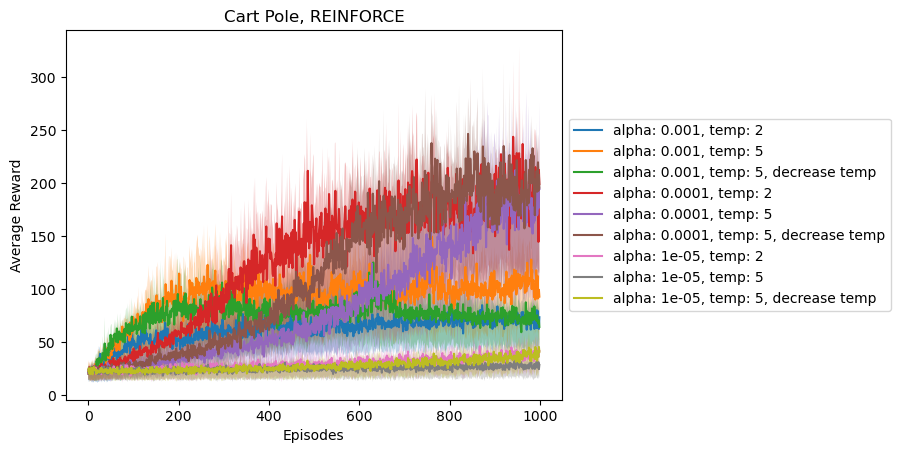

In [40]:
# cart pole
results = []
labels = []
experiments = []

for alpha in alphas:
    for temp in temps:
        params = {
            'alpha': alpha,
            'temp': temp,
            'isMountainCar': False,
            'isDecreaseTemp': False
        }
        experiments.append(params)
        labels.append("alpha: {}, temp: {}".format(alpha, temp))

    # add decreasing temperature manually
    params = {
        'alpha': alpha,
        'temp': 5,
        'isMountainCar': False,
        'isDecreaseTemp': True
    }
    experiments.append(params)
    labels.append("alpha: {}, temp: {}, decrease temp".format(alpha, temp))

with multiprocess.Pool(processes=NUM_PROCESSES) as pool:
    results = pool.starmap(run_experiment_q3,
                           [('reinforce', experiment['alpha'], GAMMA, NUM_TILINGS, NUM_TILES_PER_TILING,
                             experiment['temp'], NUM_EPISODES, NUM_TRIALS, experiment['isMountainCar'],
                             experiment['isDecreaseTemp']) for experiment in experiments])

for result, label in zip(results, labels):
    plt.plot(np.mean(result, axis=0), label=label)
    plt.fill_between(range(len(result[0])), np.percentile(result, 25, axis=0), np.percentile(result, 75, axis=0),
                     alpha=0.3)
plt.title("Cart Pole, REINFORCE")
plt.xlabel("Episodes")
plt.ylabel("Average Reward")
plt.legend()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

#### 3.5.3 Actor-Critic - Mountain Car

In [ ]:
# mountain car
results = []
labels = []
experiments = []
for alpha in alphas:
    for temp in temps:
        params = {
            'alpha': alpha,
            'temp': temp,
            'isMountainCar': True,
            'isDecreaseTemp': False
        }
        experiments.append(params)
        labels.append("alpha: {}, temp: {}".format(alpha, temp))

    # add decreasing temperature manually
    params = {
        'alpha': alpha,
        'temp': 5,
        'isMountainCar': True,
        'isDecreaseTemp': True
    }
    experiments.append(params)
    labels.append("alpha: {}, temp: {}, decrease temp".format(alpha, temp))

with multiprocess.Pool(processes=NUM_PROCESSES) as pool:
    results = pool.starmap(run_experiment_q3,
                           [('actor_critic', experiment['alpha'], GAMMA, NUM_TILINGS, NUM_TILES_PER_TILING,
                             experiment['temp'], NUM_EPISODES, NUM_TRIALS, experiment['isMountainCar'],
                             experiment['isDecreaseTemp']) for experiment in experiments])

for result, label in zip(results, labels):
    plt.plot(np.mean(result, axis=0), label=label)
    plt.fill_between(range(len(result[0])), np.percentile(result, 25, axis=0), np.percentile(result, 75, axis=0),
                     alpha=0.3)
plt.title("Mountain Car, Actor-Critic")
plt.xlabel("Episodes")
plt.ylabel("Average Reward")
plt.legend()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

#### 3.5.4 Actor-Critic - Cart Pole

In [ ]:
# cart pole
results = []
labels = []
experiments = []
for alpha in alphas:
    for temp in temps:
        params = {
            'alpha': alpha,
            'temp': temp,
            'isMountainCar': False,
            'isDecreaseTemp': False
        }
        experiments.append(params)
        labels.append("alpha: {}, temp: {}".format(alpha, temp))

    # add decreasing temperature manually
    params = {
        'alpha': alpha,
        'temp': 5,
        'isMountainCar': False,
        'isDecreaseTemp': True
    }
    experiments.append(params)
    labels.append("alpha: {}, temp: {}, decrease temp".format(alpha, temp))

with multiprocess.Pool(processes=NUM_PROCESSES) as pool:
    results = pool.starmap(run_experiment_q3,
                           [('actor_critic', experiment['alpha'], GAMMA, NUM_TILINGS, NUM_TILES_PER_TILING,
                             experiment['temp'], NUM_EPISODES, NUM_TRIALS, experiment['isMountainCar'],
                             experiment['isDecreaseTemp']) for experiment in experiments])

for result, label in zip(results, labels):
    plt.plot(np.mean(result, axis=0), label=label)
    plt.fill_between(range(len(result[0])), np.percentile(result, 25, axis=0), np.percentile(result, 75, axis=0),
                     alpha=0.3)
plt.title("Cart Pole, Actor-Critic")
plt.xlabel("Episodes")
plt.ylabel("Average Reward")
plt.legend()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [121]:
run_experiment_q3("reinforce", 0.001, 0.99, 8, 1000, 5, 1000, 1, False, True)

KeyboardInterrupt: 